Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import re
import missingno as msno
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.float_format', '{:.0f}'.format)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/data" 

dacon_2101124.csv  dacon_baseline.csv	  train_err_data.csv
dacon_2101125.csv  sample_submission.csv  train_problem_data.csv
dacon_2101126.csv  test_err_data.csv	  train_quality_data.csv
dacon_2101127.csv  test_quality_data.csv


In [6]:
path = "/content/gdrive/MyDrive/data"
train_problem = path + '/train_problem_data.csv'
train_quality = path + '/train_quality_data.csv'
train_err = path + '/train_err_data.csv'
test_err = path + '/test_err_data.csv'
test_quality = path + '/test_quality_data.csv'
sample_submission = path + '/sample_submission.csv'

In [7]:
train_prob = pd.read_csv(train_problem)
train_qual = pd.read_csv(train_quality)
train_err = pd.read_csv(train_err)
test_err = pd.read_csv(test_err)
test_qual = pd.read_csv(test_quality)
sample_submission= pd.read_csv(sample_submission)

User-defined functions

In [8]:
# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


In [9]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# 1. EDA


### Check the datasets

In [10]:
for x in [train_err, train_qual, train_prob, test_err, test_qual]:
  print( "<<", get_df_name(x), ">>" )
  display( x.shape )

<< train_err >>


(16554663, 6)

<< train_qual >>


(828624, 16)

<< train_prob >>


(5429, 2)

<< test_err >>


(16532648, 6)

<< test_qual >>


(747972, 16)

In [11]:
for x in [train_err, train_qual, train_prob, test_err, test_qual]:
  print( "<<", get_df_name(x), ">>" )
  display( x.head() )

<< train_err >>


,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


<< train_qual >>


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0,0,0,0,0,0,0,0,0,0,4,0,0


<< train_prob >>


,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


<< test_err >>


,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


<< test_qual >>


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201128195000,30000,04.33.1261,0,0,0,0,0,0,0,5,0,0,2,0,0
1,20201128195000,30000,04.33.1261,0,0,0,0,0,0,0,5,0,0,2,0,0
2,20201128195000,30000,04.33.1261,0,0,0,0,0,0,0,5,0,0,2,0,0
3,20201128195000,30000,04.33.1261,0,0,0,0,0,0,0,5,0,0,2,0,0
4,20201128195000,30000,04.33.1261,0,0,0,0,0,0,0,5,0,0,2,0,0


Check the types of data

In [12]:
for x in [train_err, train_qual, train_prob, test_err, test_qual]:
  print( "<<", get_df_name(x), ">>" )
  display( x.info() )

<< train_err >>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 757.8+ MB


None

<< train_qual >>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        828624 non-null  int64  
 1   user_id     828624 non-null  int64  
 2   fwver       788544 non-null  object 
 3   quality_0   684192 non-null  float64
 4   quality_1   828624 non-null  int64  
 5   quality_2   788511 non-null  float64
 6   quality_3   828624 non-null  int64  
 7   quality_4   828624 non-null  int64  
 8   quality_5   828604 non-null  object 
 9   quality_6   828624 non-null  int64  
 10  quality_7   828624 non-null  object 
 11  quality_8   828624 non-null  object 
 12  quality_9   828624 non-null  object 
 13  quality_10  828624 non-null  object 
 14  quality_11  828624 non-null  int64  
 15  quality_12  828624 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 101.2+ MB


None

<< train_prob >>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  5429 non-null   int64
 1   time     5429 non-null   int64
dtypes: int64(2)
memory usage: 85.0 KB


None

<< test_err >>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16532648 entries, 0 to 16532647
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      int64 
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(3), object(3)
memory usage: 756.8+ MB


None

<< test_qual >>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        747972 non-null  int64  
 1   user_id     747972 non-null  int64  
 2   fwver       725208 non-null  object 
 3   quality_0   641388 non-null  float64
 4   quality_1   747961 non-null  object 
 5   quality_2   726857 non-null  float64
 6   quality_3   747972 non-null  int64  
 7   quality_4   747972 non-null  int64  
 8   quality_5   747928 non-null  object 
 9   quality_6   747972 non-null  int64  
 10  quality_7   747972 non-null  object 
 11  quality_8   747972 non-null  object 
 12  quality_9   747972 non-null  object 
 13  quality_10  747972 non-null  object 
 14  quality_11  747972 non-null  int64  
 15  quality_12  747972 non-null  int64  
dtypes: float64(2), int64(7), object(7)
memory usage: 91.3+ MB


None

In [13]:
train_err["model_nm"].value_counts()

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

In [14]:
for x in [train_err, train_qual]:
  print( "<<", get_df_name(x), ">>" )
  display( x.describe() )

<< train_err >>


,user_id,time,errtype
count,16554663,16554663,16554663
mean,17585,20201115695081,21
std,4342,8664375,10
min,10000,20201031235959,1
25%,13925,20201108122625,15
50%,17485,20201116030018,23
75%,21227,20201123135610,31
max,24999,20201202185152,42


<< train_qual >>


,time,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_6,quality_11,quality_12
count,828624,828624,684192,828624,788511,828624,828624,828624,828624,828624
mean,20201115421121,17575,4,-0,5,0,0,2,-0,0
std,8863638,4374,479,1,586,0,0,33,0,0
min,20201031235000,10000,-1,-1,-1,0,0,-1,-1,0
25%,20201108102750,13685,0,0,0,0,0,0,0,0
50%,20201115182500,17597,0,0,0,0,0,0,0,0
75%,20201123131000,21423,0,0,0,0,0,0,0,0
max,20201130234000,24997,157667,171,191859,0,0,600,14,14


Check whether there exist any missing values

Check the null values by column_wise

In [15]:
for x in [train_err, train_qual]:
  print( "<<", get_df_name(x), ">>" )
  display( x.isnull().sum() )

<< train_err >>


user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64

<< train_qual >>


time               0
user_id            0
fwver          40080
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5         20
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
dtype: int64

Check the null values by row_wise

In [16]:
train_qual.isnull().sum(axis=1).sort_values(ascending=False)

737513    3
531421    3
531423    3
531424    3
531425    3
         ..
523650    0
523649    0
523648    0
523647    0
0         0
Length: 828624, dtype: int64

### Missing Values

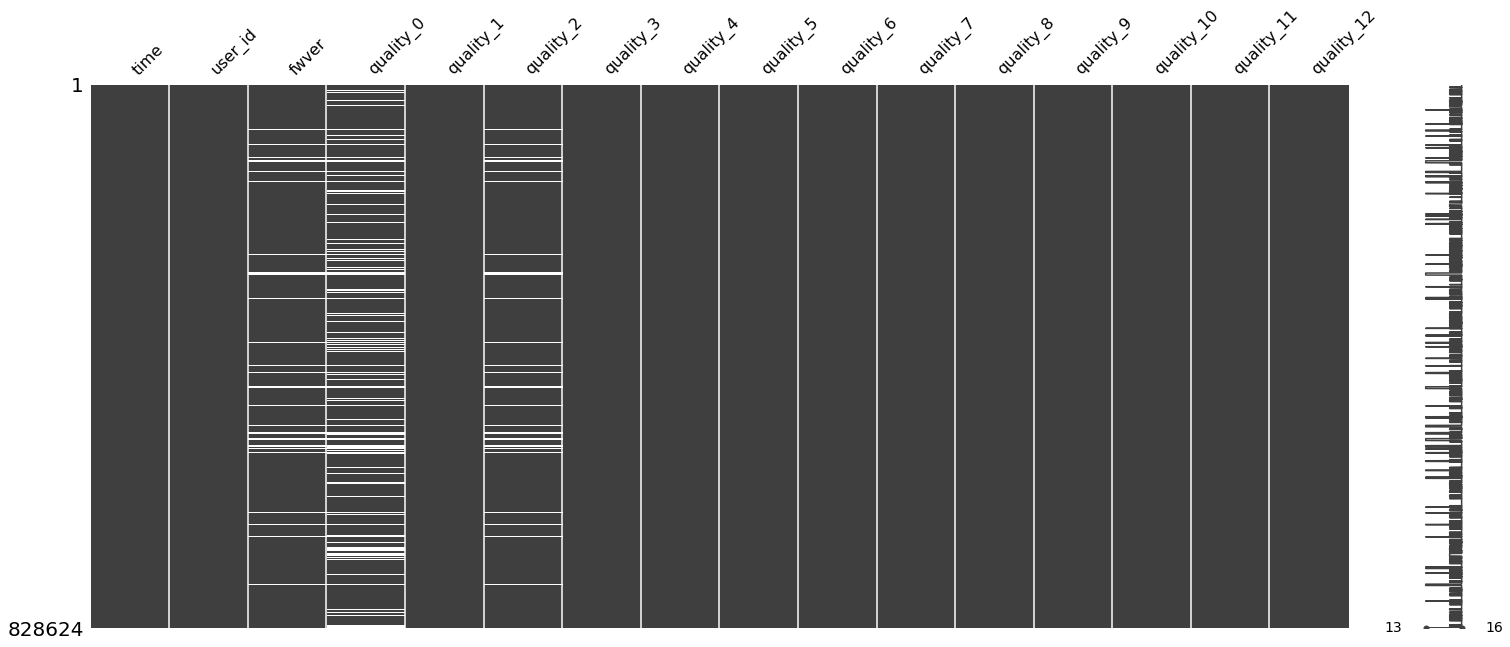

In [17]:
msno.matrix(train_qual)

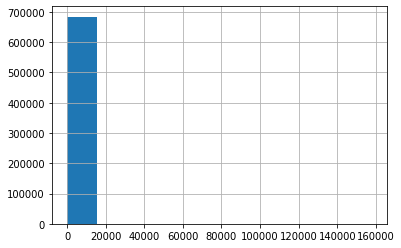

In [18]:
train_qual["quality_0"].hist()

In [19]:
train_qual["quality_0"][ train_qual["quality_0"] < 150000 ].describe()

count   684191
mean         4
std        440
min         -1
25%          0
50%          0
75%          0
max     134235
Name: quality_0, dtype: float64

In [21]:
train_qual["quality_0"].value_counts()

0       542790
-1      130828
1         2097
2         1252
3          518
         ...  
957          1
3835         1
959          1
3837         1
2039         1
Name: quality_0, Length: 753, dtype: int64

## train_err, test_err


In [22]:
display( "train_err[user_id]", train_err["user_id"].agg(["min", "max"]) )
display( "test_err[user_id]", test_err["user_id"].agg(["min", "max"]) )

'train_err[user_id]'

min    10000
max    24999
Name: user_id, dtype: int64

'test_err[user_id]'

min    30000
max    44998
Name: user_id, dtype: int64

In [23]:
display( "train_err[time]", train_err["time"].agg(["min", "max"]) )
display( "test_err[time]", test_err["time"].agg(["min", "max"]) )

'train_err[time]'

min    20201031235959
max    20201202185152
Name: time, dtype: int64

'test_err[time]'

min    20201031235959
max    20201214120118
Name: time, dtype: int64

In [24]:
display( "train_err[errtype]", train_err["errtype"].agg(["min", "max"]) )
display( "test_err[errtype]", test_err["errtype"].agg(["min", "max"]) )

'train_err[errtype]'

min     1
max    42
Name: errtype, dtype: int64

'test_err[errtype]'

min     1
max    42
Name: errtype, dtype: int64

## train_qual, test_qual


#### quality_0 ~ quality_12

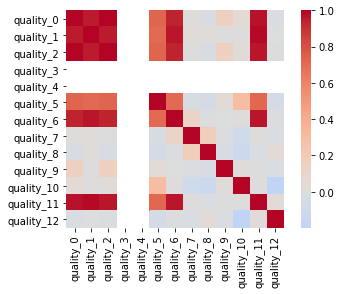

In [39]:
quality_comma = []
for j in ["quality_" + str(j) for j in range(0, 13)]:
        if (train_qual[j].map(lambda x: len(re.findall(",", str(x))) > 0).sum()):
            display(j, train_qual[j].str.contains(",").sum())
            quality_comma.append(j)

for j in quality_comma:
        idx_comma = train_qual[j].str.contains(",", na=False)
        train_qual[j][ idx_comma ] = train_qual[j][ idx_comma ].map(lambda x: str(x).split(",")[0])

for j in train_qual.filter(regex="quality").columns:
        train_qual[j] = train_qual[j].astype(float)

"""## Correlation between quality scores"""

eda_qual_corr = train_qual.filter(regex="quality_[0-9]+").corr(method = "spearman")
sns.heatmap(eda_qual_corr, cmap="coolwarm", square=True, center=0)

'quality_1'

1

'quality_5'

3876

'quality_7'

4488

'quality_8'

36

'quality_9'

1488

'quality_10'

39324

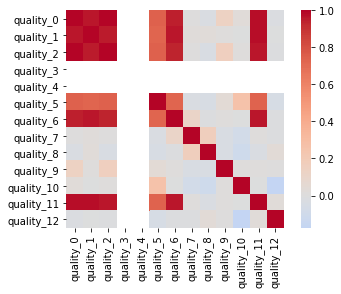

In [40]:
quality_comma = []
for j in ["quality_" + str(j) for j in range(0, 13)]:
        if (test_qual[j].map(lambda x: len(re.findall(",", str(x))) > 0).sum()):
            display(j, test_qual[j].str.contains(",").sum())
            quality_comma.append(j)

for j in quality_comma:
        idx_comma = test_qual[j].str.contains(",", na=False)
        test_qual[j][ idx_comma ] = test_qual[j][ idx_comma ].map(lambda x: str(x).split(",")[0])

for j in test_qual.filter(regex="quality").columns:
        test_qual[j] = test_qual[j].astype(float)

"""## Correlation between quality scores"""

eda_qual_corr = test_qual.filter(regex="quality_[0-9]+").corr(method = "spearman")
sns.heatmap(eda_qual_corr, cmap="coolwarm", square=True, center=0)

#### fwver

In [41]:
train_err_errtype_set = set(train_err['fwver'])
test_err_errtype_set = set(test_err['fwver'])

display( "The number of categories that uniquely exists in the train :", len( train_err_errtype_set ) )
display( "The number of categories that uniquely exists in the test :", len( test_err_errtype_set ) )

display( "Existing in train but not in test", train_err_errtype_set.difference(test_err_errtype_set) )
display( "Existing in test but not in train", test_err_errtype_set.difference(train_err_errtype_set) )

'The number of categories that uniquely exists in the train :'

37

'The number of categories that uniquely exists in the test :'

40

'Existing in train but not in test'

{'04.16.2641',
 '04.16.3345',
 '04.22.1442',
 '04.33.1095',
 '05.15.2090',
 '05.15.2122'}

'Existing in test but not in train'

{'04.22.1170',
 '04.22.1448',
 '04.22.1478',
 '04.22.1608',
 '04.22.1772',
 '04.73.2569',
 '04.73.2577',
 '10.22.1770',
 '10.22.1780'}

In [42]:
train_err["fwver"].value_counts()

04.16.3553    5237816
04.22.1750    2874213
04.33.1261    2504871
05.15.2138    1906479
03.11.1167    1505659
04.22.1778    1293946
04.33.1185     963736
04.16.3571     145156
04.73.2237      33537
05.66.3237      31832
04.82.1684      23554
04.82.1778       8601
04.22.1684       5554
05.66.3571       3524
04.33.1149       3272
04.73.2571       2527
04.22.1442       2522
03.11.1149       2114
10               1534
04.16.3569        980
04.33.1095        909
05.15.2120        706
04.33.1125        408
04.16.2641        296
8.5.3             212
05.15.3104        191
04.16.3439        142
04.16.3345        101
04.82.1730         78
04.33.1171         58
04.22.1656         39
03.11.1141         29
05.15.2122         23
05.15.2092         18
05.15.2090         12
05.15.2114          9
04.22.1666          5
Name: fwver, dtype: int64

In [35]:
# Each individual has at most 4 observations
print(train_err[["user_id", "fwver"]].groupby("user_id").fwver.nunique().value_counts().sum())
print(train_qual[["user_id", "fwver"]].groupby("user_id").fwver.nunique().value_counts().sum())

15000
8281


In [43]:
# train_err and train_qual can differ
train_err[["user_id", "fwver"]].groupby("user_id").fwver.unique()

user_id
10000                [05.15.2138]
10001    [04.33.1185, 04.33.1261]
10002                [05.15.2138]
10003    [04.33.1185, 04.33.1261]
10004    [04.22.1750, 04.22.1778]
                   ...           
24995                [04.33.1261]
24996                [05.15.2138]
24997    [04.22.1750, 04.22.1778]
24998    [04.22.1750, 04.22.1778]
24999                [05.15.2138]
Name: fwver, Length: 15000, dtype: object

In [44]:
train_qual[["user_id", "fwver"]].groupby("user_id").fwver.unique()

user_id
10000                [05.15.2138]
10002                [05.15.2138]
10004                [04.22.1750]
10005                [04.22.1750]
10006    [04.16.3553, 04.33.1261]
                   ...           
24990                [03.11.1167]
24992                [04.22.1750]
24993                [05.15.2138]
24995                [04.33.1261]
24997    [04.22.1750, 04.22.1778]
Name: fwver, Length: 8281, dtype: object

In [47]:
# The length of unique elements of fwver values from train_err and train_qual
df_fwver_nunique_count = pd.merge( train_err[["user_id", "fwver"]].groupby("user_id").fwver.nunique().reset_index(),
                                   train_qual[["user_id", "fwver"]].groupby("user_id").fwver.nunique().reset_index(),
                                   how = "left", on="user_id" )

df_fwver_tmp = df_fwver_nunique_count[ ~df_fwver_nunique_count.fwver_y.isnull() ].apply(lambda x: str(x[1]) != str(x[2]), axis=1)

In [49]:
# The total number of rows having different fwver counts is 3053
df_fwver_tmp.sum()
diff_fwever_btw_err_and_qual = df_fwver_nunique_count.loc[ df_fwver_tmp[df_fwver_tmp].index, : ]

3053

In [50]:
# Among them, 3030 rows have more fwver values in train_err than in train_qual
( diff_fwever_btw_err_and_qual.fwver_x > diff_fwever_btw_err_and_qual.fwver_y ).sum()

3030

In [54]:
# That might be because train_err and train_qual sets have different number of observations at time although the same user_id.
display(train_err.groupby(["user_id"]).user_id.count())
display(train_qual.groupby(["user_id"]).user_id.count())

user_id
10000     317
10001    2365
10002     306
10003     306
10004     777
         ... 
24995     194
24996       4
24997     826
24998     155
24999     570
Name: user_id, Length: 15000, dtype: int64

user_id
10000    24
10002    96
10004    24
10005    24
10006    36
         ..
24990    24
24992    36
24993    24
24995    24
24997    24
Name: user_id, Length: 8281, dtype: int64

In [55]:
len( set(train_err.user_id.unique()).difference(set(train_qual.user_id.unique() )) )
len( set(train_qual.user_id.unique() ).difference( set(train_err.user_id.unique()) ) )

0

# 2.Generating New Variables 

## Preprocess Fuction

In [19]:
# Remove rows with a missing value at the column of errcode.
train_err.drop(train_err.index[train_err["errcode"].isnull()], inplace=True)

In [20]:
def preprocess_err(df):
  
    ########## Date #########
    time = df['time'].astype(str)
    df['month'] = [int(x[4:6]) for x in time ] 
    df['day']   = [int(x[6:8]) for x in time ] 
    df['hour']  = [int(x[8:10]) for x in time ] 

    #days
    df['datetime'] = df['time'].apply(make_datetime)
    min_day = df.datetime.min().date()
    df['days'] = df.loc[:,'datetime'].dt.date - min_day
    df['days'] = df['days'].dt.days

    ######### errcode #########
    err = df["errcode"]

    # New Variable (errcode_numeric) :: whether each variable is numeric or not
    df["errcode_numeric"] = err.map(lambda x: 1 if str(x).replace("-", "").isdigit() else 0)

    # New Variable (errcode_digit) :: the number of digits for each
    df["errcode_digits"] = err.map(lambda s: len(re.findall("[0-9]", str(s))) if str(s).isdigit() else 0)

    # errcode_sparse
    idx_errcode_100000 = list(err.value_counts()[err.value_counts() > 100000].index)
    df["errcode_sparse"] = err
    df.loc[~err.isin(idx_errcode_100000), "errcode_sparse"] = "sparse"

    return df


In [21]:
def preprocess_qual(df):

    ########## Date #########
    time = df['time'].astype(str)
    df['month'] = [int(x[4:6]) for x in time ] 
    df['day']   = [int(x[6:8]) for x in time ] 
    df['hour']  = [int(x[8:10]) for x in time ] 

    # days
    df['datetime'] = df['time'].apply(make_datetime)
    min_day = df.datetime.min().date()
    df['days'] = df.loc[:,'datetime'].dt.date - min_day
    df['days'] = df['days'].dt.days

    ######### quality #########
    quality_comma = []
    for j in ["quality_" + str(j) for j in range(0, 13)]:
        if (df[j].map(lambda x: len(re.findall(",", str(x))) > 0).sum()):
            display(j, df[j].str.contains(",").sum())
            quality_comma.append(j)

    for j in quality_comma:
        idx_comma = df[j].str.contains(",", na=False)
        df[j][ idx_comma ] = df[j][ idx_comma ].map(lambda x: str(x).split(",")[0])

    for j in df.filter(regex="quality").columns:
        df[j] = df[j].astype(float)

    ######## rename variables #########
    df.rename(columns = {'fwver':'qual_fwver', 'month':'qual_month', 'day':'qual_day', 'hour':'qual_hour',
                         'days':'qual_days'}, inplace = True)

    return df

In [24]:
# err
train_err = preprocess_err(train_err)

In [25]:
test_err = preprocess_err(test_err)

In [64]:
# qual
train_qual = preprocess_qual(train_qual)

In [65]:
test_qual = preprocess_qual(test_qual)

In [27]:
# save the made train_err, test_err
train_err.to_csv('gdrive/MyDrive/train_err_made.csv',index=False)
test_err.to_csv('gdrive/MyDrive/test_err_made.csv',index=False)

In [67]:
# save the made train_qual, test_qual
train_qual.to_csv('gdrive/MyDrive/train_qual_made.csv',index=False)
test_qual.to_csv('gdrive/MyDrive/test_qual_made.csv',index=False)

In [ ]:
# load the made train_err, test_err
train_err = pd.read_csv('gdrive/MyDrive/train_err_made.csv')
test_err = pd.read_csv('gdrive/MyDrive/test_err_made.csv')

In [22]:
# load the made train_qual, test_qual
train_qual = pd.read_csv('gdrive/MyDrive/train_qual_made.csv')
test_qual = pd.read_csv('gdrive/MyDrive/test_qual_made.csv')

## Feature Type

In [28]:
print(train_err.head(2))
print(train_qual.head(2))

   user_id            time  ... errcode_digits errcode_sparse
0    10000  20201101025616  ...              1              1
1    10000  20201101030309  ...              1              1

[2 rows x 14 columns]
             time  user_id  ...             datetime  qual_days
0  20201129090000    10000  ...  2020-11-29 09:00:00         29
1  20201129090000    10000  ...  2020-11-29 09:00:00         29

[2 rows x 21 columns]


In [29]:
print(train_err.columns)
print(train_qual.columns)
print(test_err.columns)
print(test_qual.columns)

Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode', 'month',
       'day', 'hour', 'datetime', 'days', 'errcode_numeric', 'errcode_digits',
       'errcode_sparse'],
      dtype='object')
Index(['time', 'user_id', 'qual_fwver', 'quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12',
       'qual_month', 'qual_day', 'qual_hour', 'datetime', 'qual_days'],
      dtype='object')
Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode', 'month',
       'day', 'hour', 'datetime', 'days', 'errcode_numeric', 'errcode_digits',
       'errcode_sparse'],
      dtype='object')
Index(['time', 'user_id', 'qual_fwver', 'quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12',
       'qual_month', 'qual_day', 'qual_hour'

In [30]:
# err features
FEATURES_CONTINUOUS = ["month", "day", "hour", "days"]
FEATURES_CATEGORICAL = ["model_nm", "fwver", "errtype",
                         "errcode_numeric", "errcode_digits", "errcode_sparse"]
TARGET = "problem"

In [31]:
# qual features
FEATURES_CONTINUOUS = ["qual_month", "qual_day", "qual_hour", "qual_days",
                       "quality_0", "quality_1", "quality_2", "quality_3", "quality_4", "quality_5",
                       "quality_6", "quality_7", "quality_8", "quality_9", "quality_10",
                       "quality_11", "quality_12"]
FEATURES_CATEGORICAL = ["qual_fwver"]
TARGET = "problem"

#  3. Encoder

In [45]:
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

In [46]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [34]:
def isnan(value):
    try:
        import math
        return math.isnan(float(value))
    except:
        return False

### Encode Fuction

**category** variables

In [37]:
def encode_cat(train_df, test_df, var, type):
  
    uni_train_var = train_df[var].unique()
    uni_test_var =  test_df[var].unique()

    li1 = [x for x in uni_train_var if x in uni_test_var]
    li2 = [x for x in uni_train_var if x not in uni_test_var]
    li3 = [x for x in uni_test_var if x not in uni_train_var]
    co_uni_var = np.unique(np.asarray(li1+li2+li3))
    co_uni_var.sort()
    co_uni_var = co_uni_var.astype(str)

    if type == 1 : 
      df = train_df
      user_number = train_user_number
      user_id_min = train_user_id_min 
    elif type == 2  :
      df = test_df
      user_number = test_user_number
      user_id_min = test_user_id_min


    id_var = df[['user_id',var]].values
    encode = np.zeros((user_number, co_uni_var.shape[0]))

    for person_idx, val in tqdm(id_var):
      if isnan(val):
        col = encode.shape[1] - 1
        encode[np.int(person_idx - user_id_min), col] += 1
      else :
        col = np.int(np.where(co_uni_var == str(val))[0])
        encode[np.int(person_idx - user_id_min), col] += 1

    pdf = pd.DataFrame(encode, columns=[str(var) + '_' + str(x) for x in co_uni_var])

    # model_nm 하나라도 있으면 1, 아니면 0
    for j in pdf.filter(regex="model_nm").columns:
      pdf.loc[ pdf[j] > 0, j] = 1

    return(pdf)

In [36]:
# train_err category encode
model_pd = encode_cat(train_err, test_err, "model_nm", 1)
fwver_pd = encode_cat(train_err, test_err, "fwver", 1)
errtype_pd = encode_cat(train_err, test_err, "errtype", 1)
errcode_numeric_pd = encode_cat(train_err, test_err, "errcode_numeric", 1)
errcode_digits_pd = encode_cat(train_err, test_err, "errcode_digits", 1)
errcode_sparse_pd = encode_cat(train_err,test_err, "errcode_sparse", 1)

100%|██████████| 16554662/16554662 [02:23<00:00, 115123.03it/s]
0it [00:00, ?it/s]
100%|██████████| 16554662/16554662 [02:38<00:00, 104158.61it/s]
0it [00:00, ?it/s]
100%|██████████| 16554662/16554662 [02:28<00:00, 111238.25it/s]
0it [00:00, ?it/s]
100%|██████████| 16554662/16554662 [02:29<00:00, 110932.25it/s]
0it [00:00, ?it/s]
100%|██████████| 16554662/16554662 [02:11<00:00, 125421.04it/s]
0it [00:00, ?it/s]


In [56]:
# test_err category encode
test_model_pd = encode_cat(train_err, test_err, "model_nm", 2)
test_fwver_pd =  encode_cat(train_err, test_err, "fwver", 2)
test_errtype_pd = encode_cat(train_err, test_err, "errtype", 2)
test_errcode_numeric_pd = encode_cat(train_err, test_err, "errcode_numeric", 2)
test_errcode_digits_pd = encode_cat(train_err, test_err, "errcode_digits", 2)
test_errcode_sparse_pd = encode_cat(train_err, test_err, "errcode_sparse", 2)

100%|██████████| 16532648/16532648 [02:14<00:00, 122935.77it/s]


In [66]:
# train_qual, test_qual category encode
qual_fwver_pd = encode_cat(train_qual, test_qual, "qual_fwver", 1)
test_qual_fwver_pd = encode_cat(train_qual, test_qual, "qual_fwver", 2)

100%|██████████| 747972/747972 [00:06<00:00, 118376.79it/s]


**continuous** variables

In [57]:
def npmean(x):
  return(np.mean(x))

def npmin(x):
  return(np.min(x))

def npmax(x):
  return(np.max(x))

def npstd(x):
  return(np.std(x))

In [58]:
def encode_qual_time(df):
  err_time_encode = df.filter(regex="month|day|hour|user_id|quality_[0-9]+").groupby(['user_id']).agg([npmean,npmin,npmax, npstd])
  err_time_encode.columns = ["_".join(x) for x in err_time_encode.columns.ravel()]
  return(err_time_encode)

In [41]:
train_err_time = encode_qual_time(train_err)
train_qual_time = encode_qual_time(train_qual)

In [59]:
test_err_time = encode_qual_time(test_err)
test_qual_time = encode_qual_time(test_qual)

### combine encode data

In [47]:
def err_comb(model, fwver, errtype, errcode_numeric, errcode_digits, errcode_sparse, err_time, type):
    if type==1 :
        user_id_min = train_user_id_min  
    elif type==2:
        user_id_min = test_user_id_min

    err_encode1 = pd.concat([model, fwver, errtype, errcode_numeric, errcode_digits, errcode_sparse], axis=1).reset_index()
    err_encode1['user_id']=err_encode1['index']+  user_id_min
    err_encode1.drop(["index"], axis=1, inplace=True)
    err_encode = pd.merge(err_encode1, err_time, on="user_id" ,how="left")

    cols = [col for col in err_encode if col!='user_id']
    err_encode = err_encode[cols]

    return(err_encode)

In [48]:
def qual_comb(fwver, qual_time, type):
      if type==1 :
        user_id_min = train_user_id_min  
      elif type==2:
        user_id_min = test_user_id_min

      qual_encode1 = fwver.reset_index()
      qual_encode1['user_id']= qual_encode1['index']+ user_id_min
      qual_encode1.drop(["index"], axis=1, inplace=True)
      qual_encode = pd.merge(qual_encode1, qual_time,on="user_id" ,how="left")

      cols = [col for col in qual_encode if col!='user_id']
      qual_encode = qual_encode[cols]
      
      return(qual_encode)


In [49]:
train_err_encode = err_comb(model_pd, fwver_pd, errtype_pd, errcode_numeric_pd, errcode_digits_pd, errcode_sparse_pd, train_err_time, 1)

In [60]:
test_err_encode = err_comb(test_model_pd, test_fwver_pd, test_errtype_pd, test_errcode_numeric_pd, test_errcode_digits_pd, test_errcode_sparse_pd, test_err_time, 2)

In [67]:
train_qual_encode = qual_comb(qual_fwver_pd, train_qual_time,1)

In [68]:
test_qual_encode = qual_comb(test_qual_fwver_pd, test_qual_time,2)

combine encode

In [69]:
train_comb_encode =pd.concat([train_err_encode, train_qual_encode], axis=1)

In [70]:
test_comb_encode =pd.concat([test_err_encode, test_qual_encode], axis=1)

In [71]:
# check dimension
print(train_err_encode.shape)
print(test_err_encode.shape)
print(train_qual_encode.shape)
print(test_qual_encode.shape)
print(train_comb_encode.shape)
print(test_comb_encode.shape)

(15000, 138)
(14999, 138)
(15000, 96)
(14999, 96)
(15000, 234)
(14999, 234)


In [55]:
# save train_err, train_qual, comb encode data
train_err_encode.to_csv("gdrive/MyDrive/train_err_encode.csv",index=False)
train_qual_encode.to_csv("gdrive/MyDrive/train_qual_encode.csv",index=False)
train_comb_encode.to_csv("gdrive/MyDrive/train_comb_encode.csv",index=False)

In [73]:
# save test_err, test_qual, comb encode data
test_err_encode.to_csv("gdrive/MyDrive/test_err_encode.csv",index=False)
test_qual_encode.to_csv("gdrive/MyDrive/test_qual_encode.csv",index=False)
test_comb_encode.to_csv("gdrive/MyDrive/test_comb_encode.csv",index=False)

In [ ]:
# load
train_err_encode = pd.read_csv("gdrive/MyDrive/train_err_encode.csv")
train_qual_encode = pd.read_csv("gdrive/MyDrive/train_qual_encode.csv")

test_err_encode = pd.read_csv("gdrive/MyDrive/test_err_encode.csv")
test_qual_encode = pd.read_csv("gdrive/MyDrive/test_qual_encode.csv")

train_comb_encode = pd.read_csv("gdrive/MyDrive/train_comb_encode.csv")
test_comb_encode = pd.read_csv("gdrive/MyDrive/test_comb_encode.csv")

# 4. Modeling





In [128]:
!pip install GPyOpt
from sklearn.model_selection import KFold
from GPyOpt.methods import BayesianOptimization
import time

gc.collect() #gc 비우기

34491

In [129]:
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1
problem.shape

(15000,)

In [130]:
train_x = train_comb_encode.copy()
train_y = problem

In [131]:
test_x = test_comb_encode.copy()

In [132]:
print(train_x.shape)
print(test_x.shape)

(15000, 234)
(14999, 234)


In [133]:
# split_size = 0.35
# n_estimators = 1000
# metric = 'auc'
# ESR = 150
# seed = 20210124
# nfold = 10
# parameters = [2, 20, 1000, 0, 0, 0, 0.1, 0.1]
# 
# def f_pr_auc(probas_pred, y_true):
#     labels = y_true.get_label()
#     p, r, _ = precision_recall_curve(labels, probas_pred)
#     score = auc(r, p)
#     return "pr_auc", score, True


# Optimization objective 
def lgb_score(para):
    parameters = para[0]

    params = {
        # 'device':'gpu',
        'objective': 'binary',
        'metric': "auc",
        'learning_rate': 0.05, 
        'tree_learner': 'serial',
        'boost_from_average': 'true',
        # 'num_boost_round': n_estimators,
        'boosting_type': 'gbdt',#, 'goss', 'dart'],
        'max_depth': int(parameters[9]),
        'num_leaves': int(parameters[1]), 
        'n_estimators' : int(parameters[8]),
        'learning_rate' : parameters[10],
        # Tree Depth Regularization
        'subsample_for_bin': int(parameters[2]), # Number of samples for constructing bin
        'min_data_in_leaf': int(parameters[0]), # Minimum number of data need in a child(min_data_in_leaf) - Must be motified when using a smaller dataset
        'min_sum_hessian_in_leaf': parameters[7], # Prune by minimum hessian requirement - Minimum sum of instance weight(hessian) needed in a child(leaf)

        # Regularization L1/L2
        'reg_alpha': parameters[3], # L1 regularization term on weights (0 is no regular)
        'reg_lambda': parameters[4], # L2 regularization term on weights

        # Row/Column Sampling
        'bagging_fraction': parameters[5],# Percentage of rows used per iteration frequency.
        'bagging_freq': 1,# Iteration frequency to update the selected rows.
        'feature_fraction': parameters[6], # Percentage of columns used per iteration.


        # Dart Specific
    #     'max_drop': list(np.linspace(1, 70, 5).round(0).astype(int)), # Maximum number of dropped trees on one iteration.
    #     'rate_drop': list(np.linspace(0, .8, 10).round(2)), # Dropout - Probability to to drop a tree on one iteration.
    #     'skip_drop': list(np.linspace(.4, .6, 3).round(2)), # Probability of skipping any drop on one iteration. 
    #     'uniform_drop': [False], # Uniform weight application for trees.

        # Imbalanced Dependent Variable
        'is_unbalance': False, 

        'nthread': -1, # Multi-threading
        'verbose': -1, # Logging Iteration Progression
        # 'seed': seed # Seed for row sampling RNG.
    }
    
    modelstart= time.time()
    auc_scores = []
    k_fold = KFold(n_splits=5, shuffle=True)
    for train_idx, val_idx in k_fold.split(train_x):
        # train_idx, val_idx = list( k_fold.split(train_x) )[0]
        # split train, validation set
        X = train_x.iloc[train_idx,]
        y = train_y[train_idx,]
        valid_x = train_x.iloc[val_idx]
        valid_y = train_y[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train, d_val],
                        valid_names=['train','valid'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                      
                        )
        
        
        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > 0.5, 1, 0)

        # cal scores
        auc_score = roc_auc_score(valid_y, valid_prob)
        auc_scores.append(auc_score)

    runtime = (time.time() - modelstart)/60

    # Get Metrics
    score = np.mean( auc_score )
    
    gpyopt_output.append(
        [
        score,
        params,
        runtime
        ]
    )

    return( np.array( score ) )



In [134]:
bds = [ {'name': 'min_data_in_leaf', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'num_leaves', 'type': 'discrete', 'domain': (100, 700)},
        {'name': 'subsample_for_bin', 'type': 'continuous', 'domain': (10, 250)},
        {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'reg_lambda', 'type': 'continuous', 'domain': (0, 10)},
        {'name': 'bagging_fraction', 'type': 'continuous', 'domain': (.01, 1)},
        {'name': 'feature_fraction', 'type': 'continuous', 'domain': (.01, 1)},
        {'name': 'min_sum_hessian_in_leaf', 'type': 'continuous', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1000, 700)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (-5, -1)},
        {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.01, 0.05)}

      ]

# seed = 20210123
# %xmode Verbose
gpyopt_output = []
optimizer = BayesianOptimization(f=lgb_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 maximize=True,
                                 exact_feval=True
                                 )


# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=50)
optimizer.plot_acquisition()


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[61]	train's auc: 0.838869	valid's auc: 0.818999
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[79]	train's auc: 0.841741	valid's auc: 0.808184
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[116]	train's auc: 0.833852	valid's auc: 0.810182
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[45]	train's auc: 0.832746	valid's auc: 0.788206
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[108]	train's auc: 0.858943	valid's auc: 0.798887
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[141]	train's auc: 0.923243	valid's auc: 0.824727
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[157]	train's auc: 0.928

In [135]:
# Output
results = pd.DataFrame(gpyopt_output, columns = ['avg_auc', 'parameters', 'runtime'] )
results.to_csv("gpyopt_iterations_output.csv")
best_params = results['parameters'].iloc[np.argmax(results.avg_auc)]
best_params

{'bagging_fraction': 1.0,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 1.0,
 'is_unbalance': False,
 'learning_rate': 0.05,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 57,
 'min_sum_hessian_in_leaf': 34.086234358169634,
 'n_estimators': 700,
 'nthread': -1,
 'num_leaves': 700,
 'objective': 'binary',
 'reg_alpha': 1.0,
 'reg_lambda': 3.3509106470623164,
 'subsample_for_bin': 244,
 'tree_learner': 'serial',
 'verbose': -1}

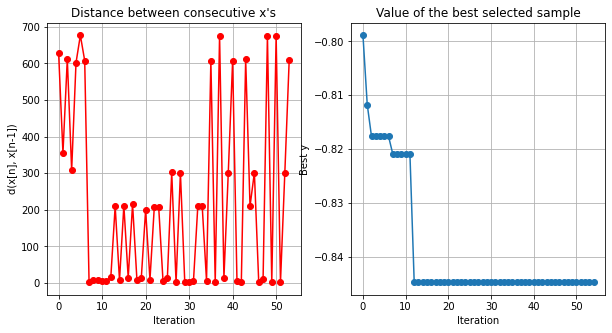

Best AUC: -0.8447728233161116
Best Parameters
{'bagging_fraction': 1.0,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 1.0,
 'is_unbalance': False,
 'learning_rate': 0.05,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 57,
 'min_sum_hessian_in_leaf': 34.086234358169634,
 'n_estimators': 700,
 'nthread': -1,
 'num_leaves': 700,
 'objective': 'binary',
 'reg_alpha': 1.0,
 'reg_lambda': 3.3509106470623164,
 'subsample_for_bin': 244,
 'tree_learner': 'serial',
 'verbose': -1}


In [136]:
import pprint

# Visualize Convergence
optimizer.plot_convergence()

print("Best AUC: {}".format(optimizer.fx_opt))
print("Best Parameters")
pprint.pprint(best_params)

Training until validation scores don't improve for 10 rounds.
[200]	train's auc: 0.937278
[400]	train's auc: 0.972981
[600]	train's auc: 0.98715
Did not meet early stopping. Best iteration is:
[700]	train's auc: 0.990858


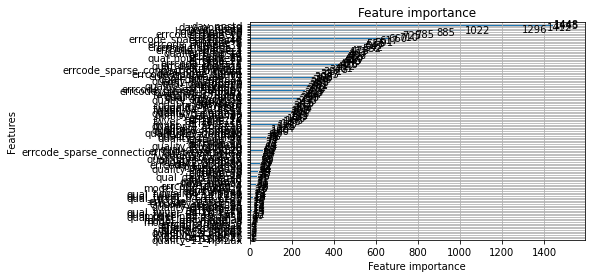

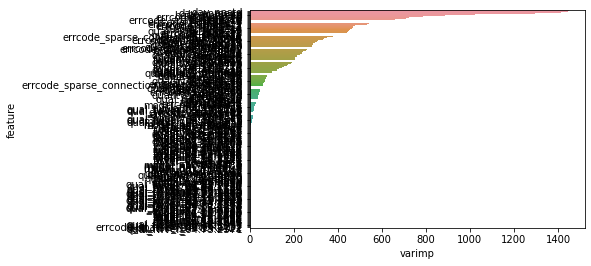

In [137]:
d_train= lgb.Dataset(train_x, train_y)
bestmodel = lgb.train(
                        best_params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train],
                        valid_names=['train'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                        )

import seaborn as sns
## 변수 중요도 시각화 
lgb.plot_importance(bestmodel)
plt.show()
feature_importance = pd.DataFrame([bestmodel.feature_name() , bestmodel.feature_importance()]).T
feature_importance.columns = ["feature", "varimp"]
feature_importance = feature_importance.sort_values(["varimp"], ascending = False)
sns.barplot(y="feature", x="varimp",data = feature_importance)
plt.show()

### variable selection

In [138]:
all_features = feature_importance[["feature", "varimp"]].sort_values(by="varimp", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features['feature'][:200])

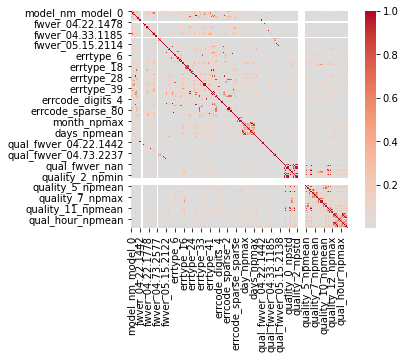

In [139]:
li1 = [x for x in train_x.columns if x in important_features]
df = pd.concat([train_x[li1], pd.Series(train_y)], axis=1)
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix, cmap="coolwarm", square=True, center=0)

In [140]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.columns
# Find index of feature columns with correlation greater than 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)

38
['errtype_12', 'errtype_16', 'errtype_21', 'errtype_23', 'errtype_27', 'errtype_28', 'errtype_37', 'errcode_numeric_0', 'errcode_digits_0', 'errcode_digits_1', 'errcode_digits_4', 'errcode_sparse_0', 'errcode_sparse_80', 'errcode_sparse_85', 'errcode_sparse_B-A8002', 'errcode_sparse_NFANDROID2', 'days_npmean', 'days_npmin', 'days_npmax', 'days_npstd', 'qual_fwver_04.22.1442', 'qual_fwver_04.22.1666', 'qual_fwver_04.33.1125', 'qual_fwver_05.15.2114', 'qual_fwver_05.15.2122', 'quality_0_npstd', 'quality_1_npmin', 'quality_2_npmean', 'quality_2_npmin', 'quality_2_npmax', 'quality_2_npstd', 'quality_6_npmin', 'quality_11_npmin', 'quality_12_npmax', 'qual_days_npmean', 'qual_days_npmin', 'qual_days_npmax', 'qual_days_npstd']


In [141]:
features = [i for i in important_features if i not in high_cor]
print(len(features))
print(features)

162
['day_npstd', 'day_npmean', 'hour_npstd', 'hour_npmean', 'errtype_26', 'errtype_15', 'errcode_sparse_sparse', 'errtype_40', 'errtype_5', 'errtype_31', 'errcode_numeric_1', 'errcode_sparse_2', 'errcode_sparse_1', 'errtype_11', 'quality_5_npstd', 'errtype_14', 'qual_hour_npmean', 'errtype_22', 'errcode_digits_2', 'qual_day_npmean', 'errtype_41', 'errcode_sparse_connection_timeout', 'qual_hour_npstd', 'qual_hour_npmin', 'errcode_sparse_active', 'errcode_sparse_14', 'errtype_33', 'qual_day_npmax', 'quality_5_npmean', 'qual_day_npmin', 'errtype_7', 'errtype_17', 'quality_10_npmean', 'errcode_sparse_standby', 'qual_hour_npmax', 'fwver_04.33.1261', 'quality_6_npstd', 'qual_day_npstd', 'errtype_34', 'quality_10_npmax', 'errtype_4', 'errtype_6', 'quality_10_npstd', 'fwver_04.33.1185', 'fwver_04.16.3553', 'quality_5_npmax', 'quality_6_npmean', 'quality_10_npmin', 'errtype_42', 'errtype_13', 'errtype_24', 'fwver_04.22.1778', 'errtype_18', 'fwver_04.22.1750', 'quality_1_npmean', 'quality_1_nps

In [142]:
ft1 = [x for x in train_x.columns if x in features]
ft2 = [x for x in test_x.columns if x in features]
train_fts = train_x[ft1]
test_fts = test_x[ft2]

In [143]:
train_x = train_fts.copy()
train_y = problem
test_x = test_fts.copy()

In [144]:
print(train_x.shape)
print(test_x.shape)

(15000, 160)
(14999, 160)


In [145]:
# seed = 20210123
# %xmode Verbose
gpyopt_output = []
optimizer = BayesianOptimization(f=lgb_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 maximize=True,
                                 exact_feval=True
                                 )


# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=50)
optimizer.plot_acquisition()


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[181]	train's auc: 0.793944	valid's auc: 0.783633
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[109]	train's auc: 0.786921	valid's auc: 0.80118
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[56]	train's auc: 0.784077	valid's auc: 0.791255
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[165]	train's auc: 0.800851	valid's auc: 0.788502
Training until validation scores don't improve for 10 rounds.
[200]	train's auc: 0.803977	valid's auc: 0.776713
Early stopping, best iteration is:
[195]	train's auc: 0.803675	valid's auc: 0.776955
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[56]	train's auc: 0.85399	valid's auc: 0.809312
Training until validation scores don't improve for 10 rounds.
Early stop

In [146]:
# Output
results = pd.DataFrame(gpyopt_output, columns = ['avg_auc', 'parameters', 'runtime'] )
results.to_csv("gpyopt_iterations_output.csv")
best_params = results['parameters'].iloc[np.argmax(results.avg_auc)]
best_params

{'bagging_fraction': 0.465706966729812,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.3927372791532985,
 'is_unbalance': False,
 'learning_rate': 0.04520083526165548,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 20,
 'min_sum_hessian_in_leaf': 17.969167504082467,
 'n_estimators': 1000,
 'nthread': -1,
 'num_leaves': 700,
 'objective': 'binary',
 'reg_alpha': 0.15068175030756736,
 'reg_lambda': 3.619910579717293,
 'subsample_for_bin': 133,
 'tree_learner': 'serial',
 'verbose': -1}

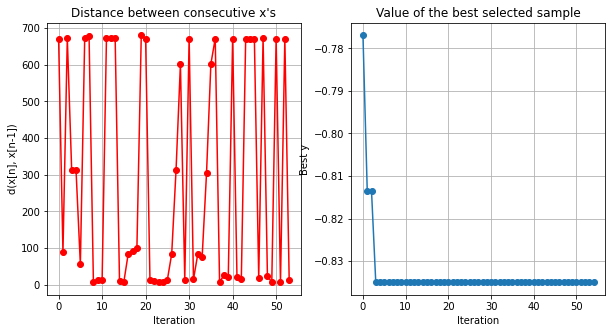

Best AUC: -0.8350164484184823
Best Parameters
{'bagging_fraction': 0.465706966729812,
 'bagging_freq': 1,
 'boost_from_average': 'true',
 'boosting_type': 'gbdt',
 'feature_fraction': 0.3927372791532985,
 'is_unbalance': False,
 'learning_rate': 0.04520083526165548,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 20,
 'min_sum_hessian_in_leaf': 17.969167504082467,
 'n_estimators': 1000,
 'nthread': -1,
 'num_leaves': 700,
 'objective': 'binary',
 'reg_alpha': 0.15068175030756736,
 'reg_lambda': 3.619910579717293,
 'subsample_for_bin': 133,
 'tree_learner': 'serial',
 'verbose': -1}


In [147]:
import pprint

# Visualize Convergence
optimizer.plot_convergence()

print("Best AUC: {}".format(optimizer.fx_opt))
print("Best Parameters")
pprint.pprint(best_params)

Training until validation scores don't improve for 10 rounds.
[200]	train's auc: 0.903362
[400]	train's auc: 0.939926
[600]	train's auc: 0.96067
[800]	train's auc: 0.973772
[1000]	train's auc: 0.981915
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.981915


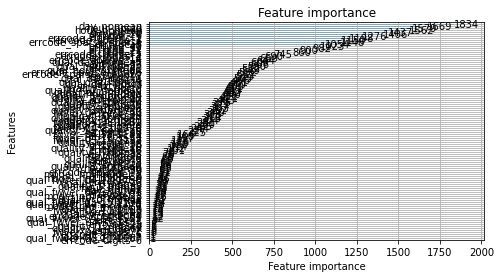

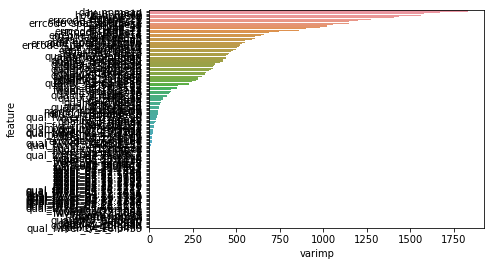

In [148]:
d_train= lgb.Dataset(train_x, train_y)
bestmodel = lgb.train(
                        best_params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train],
                        valid_names=['train'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                        )

import seaborn as sns
## 변수 중요도 시각화 
lgb.plot_importance(bestmodel)
plt.show()
feature_importance = pd.DataFrame([bestmodel.feature_name() , bestmodel.feature_importance()]).T
feature_importance.columns = ["feature", "varimp"]
feature_importance = feature_importance.sort_values(["varimp"], ascending = False)
sns.barplot(y="feature", x="varimp",data = feature_importance)
plt.show()

In [149]:
lgb_models = []

nfold = 5
folds = KFold(n_splits=nfold, shuffle=True)
for fold_, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
  train_x_i = train_x.iloc[train_index,]
  train_y_i = train_y[train_index]

  val_x_i = train_x.iloc[valid_index,]
  val_y_i = train_y[valid_index]
  
  d_train= lgb.Dataset(train_x_i, train_y_i)
  d_val= lgb.Dataset(val_x_i, val_y_i)

  lgb_models.append( lgb.train(
                        best_params,
                        train_set       = d_train,
                        num_boost_round = 100,
                        valid_sets =[d_train, d_val],
                        valid_names=['train', 'val'],
                        verbose_eval    = 200, 
                        early_stopping_rounds = 10
                        ) )
  


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[79]	train's auc: 0.85971	val's auc: 0.808461
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[128]	train's auc: 0.876812	val's auc: 0.821726
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[123]	train's auc: 0.878781	val's auc: 0.823522
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[112]	train's auc: 0.876506	val's auc: 0.808606
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[135]	train's auc: 0.885571	val's auc: 0.820198


### save submit .csv

In [150]:
# 예측
pred_y_list = []
for model in lgb_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [151]:
pred_ensemble

array([[0.88370915],
       [0.22040754],
       [0.32037834],
       ...,
       [0.57448306],
       [0.8700196 ],
       [0.37657574]])

In [152]:
sample_submission['problem'] = pred_ensemble.reshape(-1)

In [153]:
sample_submission.to_csv("gdrive/MyDrive/data/dacon_2101130.csv", index = False)
sample_submission

,user_id,problem
0,30000,1
1,30001,0
2,30002,0
3,30003,1
4,30004,1
...,...,...
14994,44994,0
14995,44995,0
14996,44996,1
14997,44997,1
